In [1]:
import warnings
import json
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
from scipy.stats import norm
import torch
from torch.utils.data import DataLoader
import pickle
import os


from varpi.wasserstein_min import get_best_lstm_pdf_params
from varpi.varpi_utils.varphi_utils import get_all_quantiles
from utils.dist_utils import generate_smooth_pdf
from utils.optuna_utils import load_qlstm_model
from utils.data_utils import get_test_dataset

warnings.filterwarnings("ignore")

with open("config.json", "r") as f:
    CONFIG = json.load(f)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

taus = CONFIG["general"]["quantiles"]

test_start_date = CONFIG["general"]["dates"]["test_period"]["start_date"]
test_end_date = CONFIG["general"]["dates"]["test_period"]["end_date"]

val_start_date = CONFIG["general"]["dates"]["validation_period"]["start_date"]
val_end_date = CONFIG["general"]["dates"]["validation_period"]["end_date"]

seed = CONFIG["general"]["seed"]
np.random.seed(seed)
torch.manual_seed(seed)


mkdir -p failed for path /home/dev/.cache/matplotlib: [Errno 13] Permission denied: '/home/dev/.cache/matplotlib'
Matplotlib created a temporary cache directory at /tmp/matplotlib-s4widq_r because there was an issue with the default path (/home/dev/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/home/dev/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the Model

In [2]:
_, qlstm_params = load_qlstm_model()
varphi = torch.load('models/varphi.pth', weights_only=False)

# Infrence the Model to get all S&P500 tickers

In [3]:
normalization_window = qlstm_params['normalazation_window']
val_dataset = get_test_dataset(normalization_lookback=normalization_window,
                                    start_date=val_start_date,
                                    end_date=val_end_date,
                                    lookforward=30,
                                    test=True)
val_quantiles = get_all_quantiles(val_dataset, varphi)

Inferencing models: 100%|██████████| 6/6 [00:14<00:00,  2.49s/it]


Pick a random index to look at the distribution

In [4]:
idx = np.random.randint(0, len(val_quantiles["s&p 500"]["all_pred_quantiles"]))
#obs_rets = val_quantiles["s&p 500"]["observed_returns"][idx]
#future_rets = val_quantiles["s&p 500"]["future_returns"][idx]
quants = val_quantiles["s&p 500"]["all_pred_quantiles"][idx]
idx

1950

In [5]:
pdf_params = get_best_lstm_pdf_params(_)

[I 2026-02-13 13:57:00,927] Using an existing study with name 'wasserstein_distance_qlstm' instead of creating a new one.


In [6]:
grid, pdf, cdf = generate_smooth_pdf(quants, np.array(taus), **pdf_params)

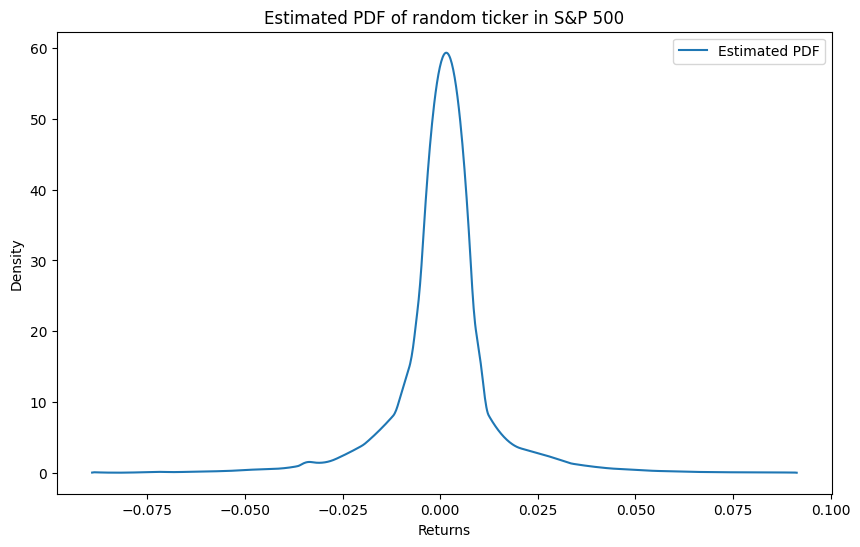

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(grid, pdf, label="Estimated PDF")
plt.ylabel("Density")
plt.xlabel("Returns")
plt.title("Estimated PDF of random ticker in S&P 500")
plt.legend()
plt.show()

In [8]:
def generate_random_walk(cdf, T):
    random_uniform_samples = np.random.uniform(0, 1, T)
    predicted_samples = np.interp(random_uniform_samples, cdf, grid)
    predicted_samples = np.concatenate([[0], predicted_samples])
    discrete_random_walk = np.cumsum(predicted_samples)
    return discrete_random_walk


In [9]:
n_samples = 10000
random_walks = []
for i in range(n_samples):
    random_walks.append(generate_random_walk(cdf, 30))
random_walks = np.array(random_walks)

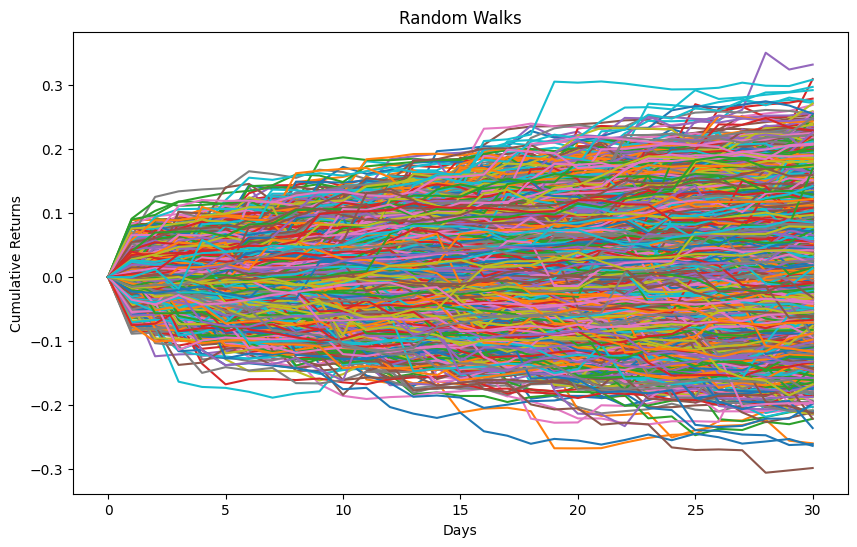

In [10]:
plt.figure(figsize=(10, 6))
for walk in random_walks:
    plt.plot(walk)
plt.ylabel("Cumulative Returns")
plt.xlabel("Days")
plt.title("Random Walks")
plt.show()

In [11]:
pdf_mean = np.trapz(grid * pdf, grid)
pdf_std = np.sqrt(np.trapz((grid - pdf_mean) ** 2 * pdf, grid))

In [12]:
theoretical_mean = []
theoretical_std = []

empircal_mean = []
empirical_std = []
for i in range(30):
    theoretical_mean.append(pdf_mean * i)
    theoretical_std.append(pdf_std * np.sqrt(i))
    
    empircal_mean.append(np.mean(random_walks[:, i]))
    empirical_std.append(np.std(random_walks[:, i]))

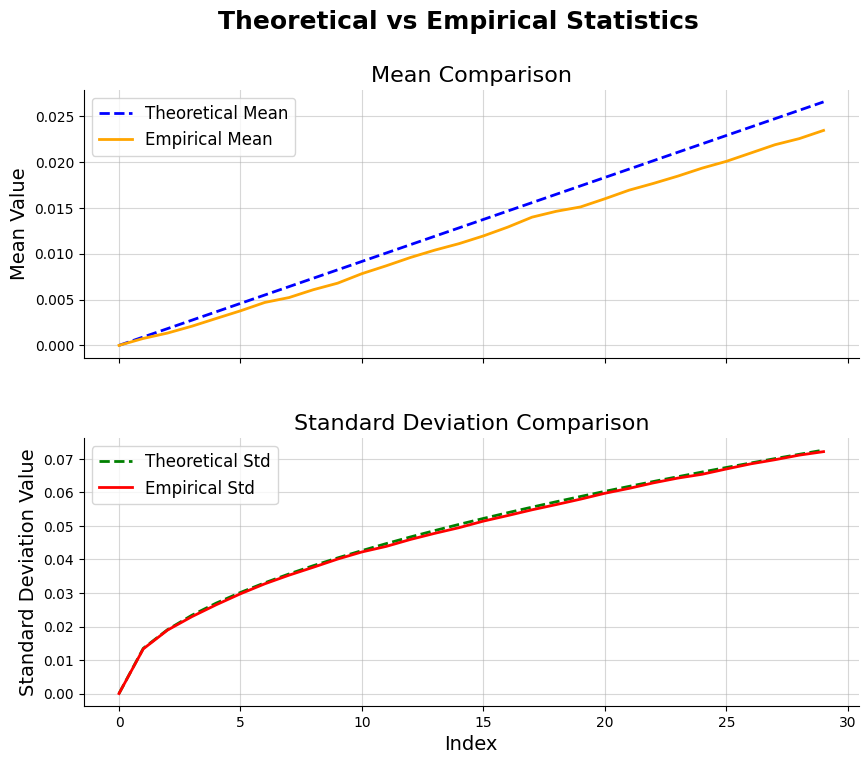

In [13]:
x = np.arange(30)

# Create the plots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'hspace': 0.3})

# First plot: Means
axes[0].plot(x, theoretical_mean, label="Theoretical Mean", linestyle="--", color="blue", linewidth=2)
axes[0].plot(x, empircal_mean, label="Empirical Mean", linestyle="-", color="orange", linewidth=2)
axes[0].set_title("Mean Comparison", fontsize=16)
axes[0].set_ylabel("Mean Value", fontsize=14)
axes[0].grid(alpha=0.5)
axes[0].legend(fontsize=12)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Second plot: Standard Deviations
axes[1].plot(x, theoretical_std, label="Theoretical Std", linestyle="--", color="green", linewidth=2)
axes[1].plot(x, empirical_std, label="Empirical Std", linestyle="-", color="red", linewidth=2)
axes[1].set_title("Standard Deviation Comparison", fontsize=16)
axes[1].set_xlabel("Index", fontsize=14)
axes[1].set_ylabel("Standard Deviation Value", fontsize=14)
axes[1].grid(alpha=0.5)
axes[1].legend(fontsize=12)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Add a unified title
fig.suptitle("Theoretical vs Empirical Statistics", fontsize=18, fontweight='bold')

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

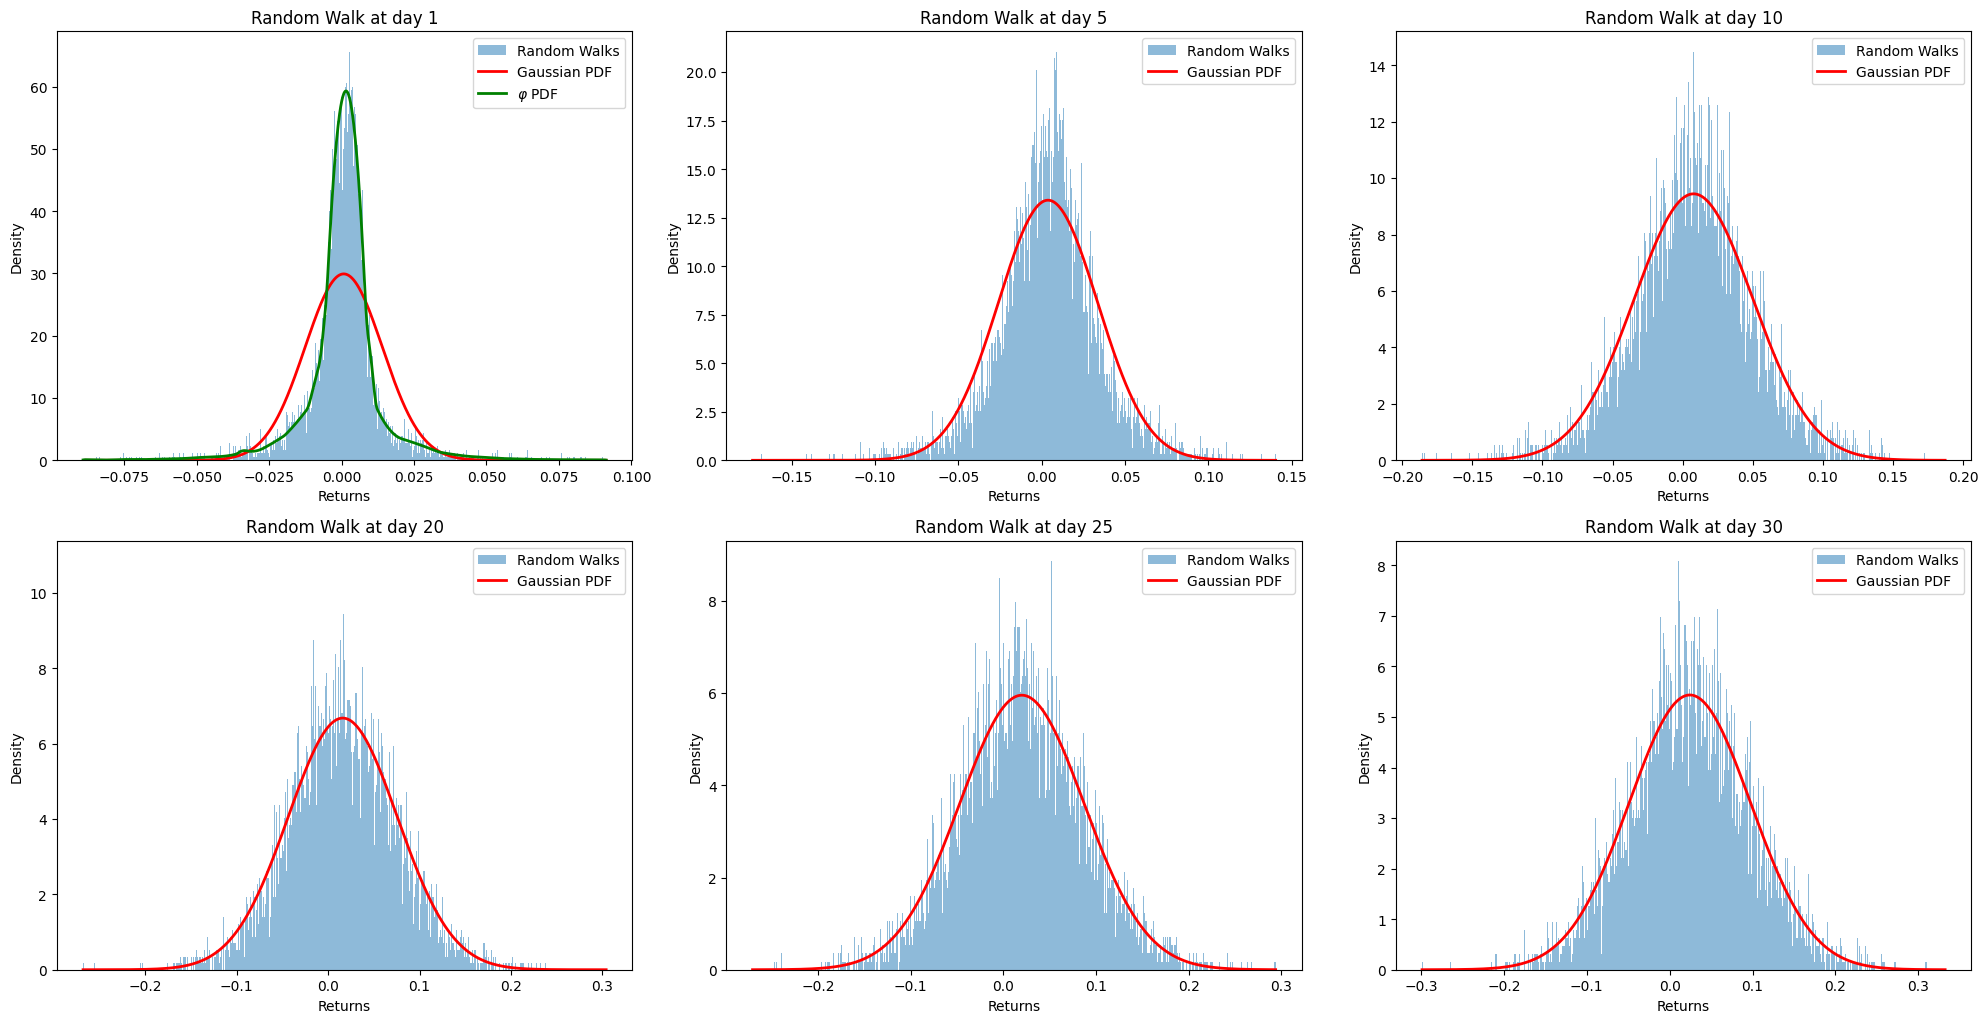

In [14]:
plt.figure(figsize=(20, 15))

plot_days = [1, 5, 10, 20, 25, 30]
num_plots = len(plot_days)
rows = (num_plots + 1) // 2  # Calculate number of rows needed
cols = 3

for idx, i in enumerate(plot_days, 1):
    plt.subplot(rows, cols, idx)
    
    plt.hist(random_walks[:, i], bins=1000, density=True, alpha=0.5, label="Random Walks")
    
    emp_mean = np.mean(random_walks[:, i])
    emp_std = np.std(random_walks[:, i])
    min_val = np.min(random_walks[:, i])
    max_val = np.max(random_walks[:, i])
    
    gaussian_grid = np.linspace(min_val, max_val, 10000)
    gaussian_pdf = norm.pdf(gaussian_grid, loc=emp_mean, scale=emp_std)
    plt.plot(gaussian_grid, gaussian_pdf, label="Gaussian PDF", color="red", linewidth=2)
    
    if i == 1:
        plt.plot(grid, pdf, label=r"$\varphi$ PDF", color="green", linewidth=2)
    
    plt.ylabel("Density")
    plt.xlabel("Returns")
    plt.title(f"Random Walk at day {i}")
    plt.legend()

plt.tight_layout()
plt.show()

In [15]:
from varpi.tain_varpi import VarPi
varpi = torch.load('models/varpi.pth',weights_only=False)

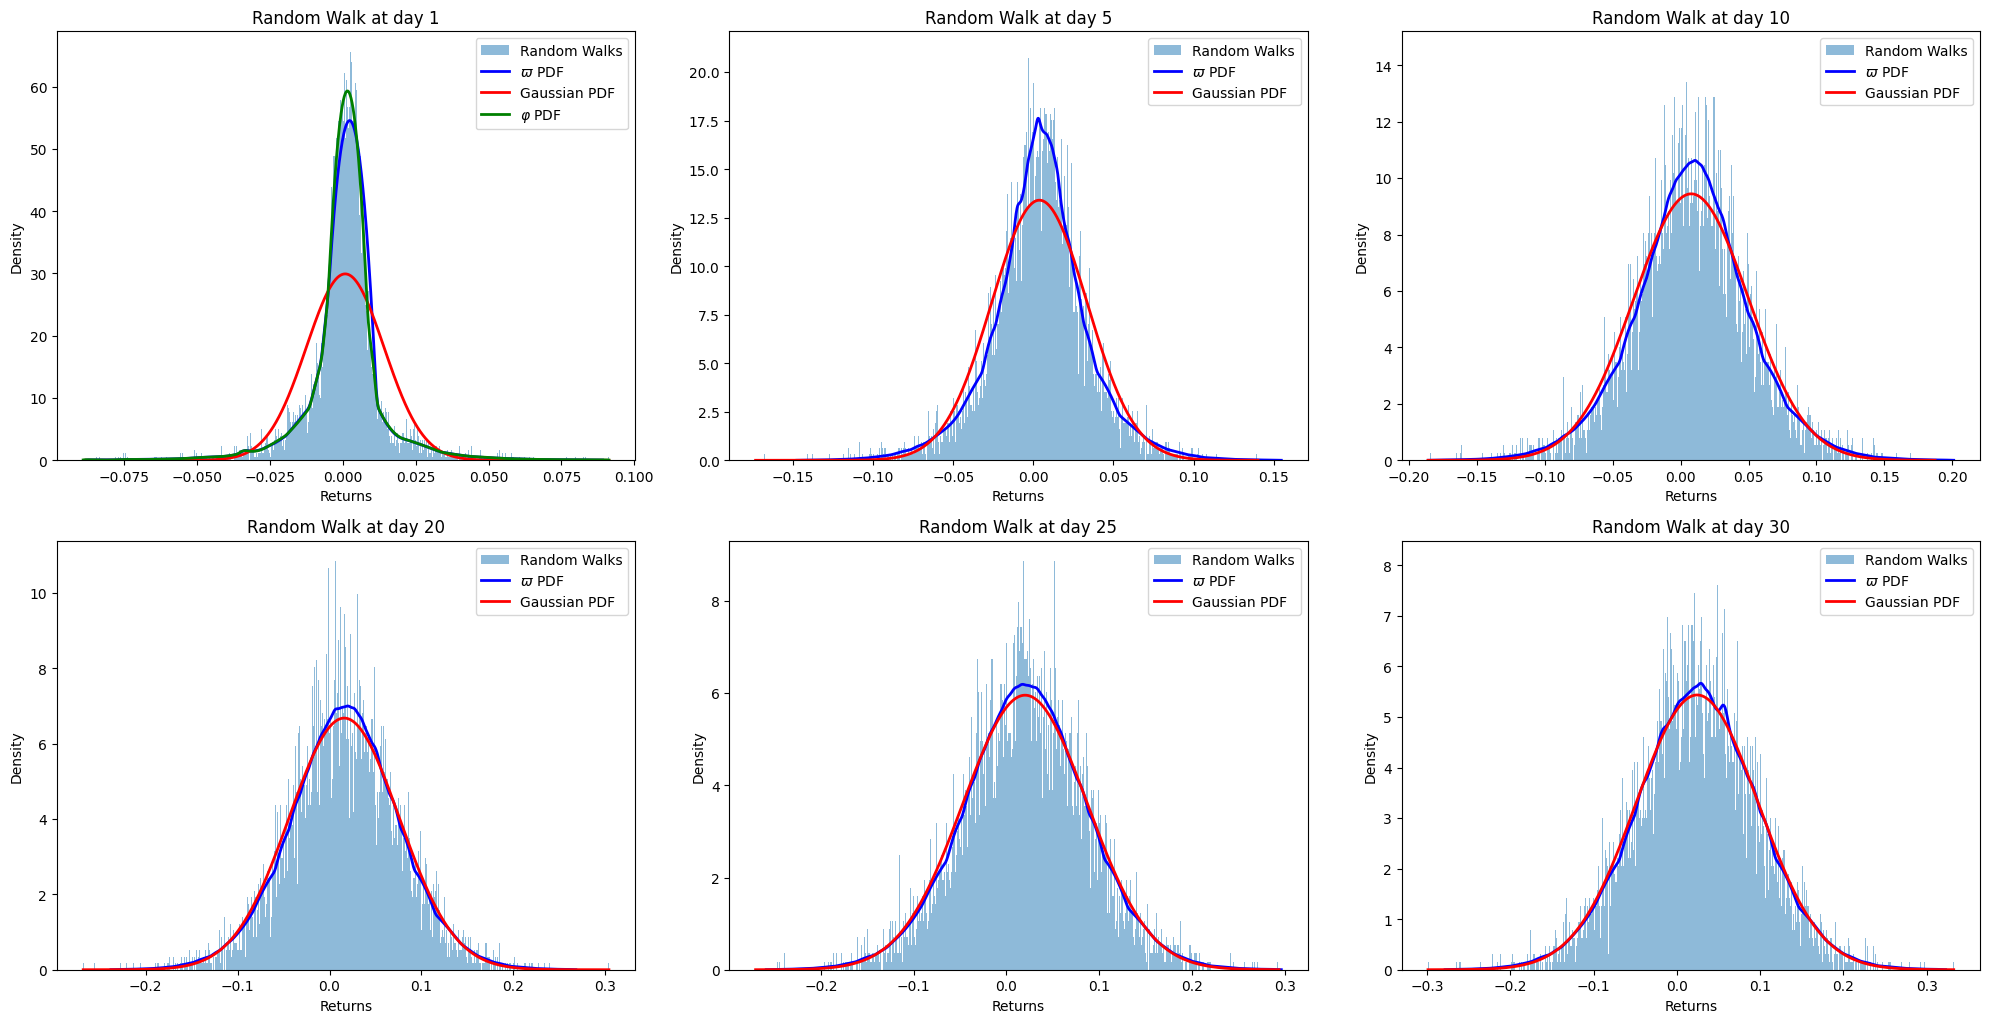

In [18]:
T = torch.tensor([1]).to(DEVICE)
quants_torch = torch.tensor(quants).to(DEVICE)
plot_days = [1, 5, 10, 20, 25, 30]
num_plots = len(plot_days)
rows = (num_plots + 1) // 2  # Calculate number of rows needed
cols = 3
fig = plt.figure(figsize=(20, 15))  # create a Figure object explicitly

varphi_mean = np.trapz(grid * pdf, grid)
varphi_std = np.sqrt(np.trapz((grid - varphi_mean) ** 2 * pdf, grid))

for idx, i in enumerate(plot_days, 1):
    plt.subplot(rows, cols, idx)
    
    plt.hist(random_walks[:, i], bins=1000, density=True, alpha=0.5, label="Random Walks")
    
    t = torch.tensor([i/30]).to(DEVICE)
    varpi_quantiles = varpi(quants_torch.unsqueeze(0), t.unsqueeze(0), T.unsqueeze(0))
    varpi_quantiles = varpi_quantiles.cpu().detach().numpy()
    
    varpi_grid, varpi_pdf, _ = generate_smooth_pdf(varpi_quantiles[0], np.array(taus), **pdf_params)
    plt.plot(varpi_grid, varpi_pdf, label=r"$\varpi$ PDF", color="blue", linewidth=2)
    
    emp_mean = np.mean(random_walks[:, i])
    emp_std = np.std(random_walks[:, i])
    min_val = np.min(random_walks[:, i])
    max_val = np.max(random_walks[:, i])
    
    gaussian_grid = np.linspace(min_val, max_val, 10000)
    gaussian_pdf = norm.pdf(gaussian_grid, loc=emp_mean, scale=emp_std)
    plt.plot(gaussian_grid, gaussian_pdf, label="Gaussian PDF", color="red", linewidth=2)
    
    
    if i == 1:
        plt.plot(grid, pdf, label=r"$\varphi$ PDF", color="green", linewidth=2)
    
    plt.ylabel("Density")
    plt.xlabel("Returns")
    plt.title(f"Random Walk at day {i}")
    plt.legend()

plt.tight_layout(rect=[0, 0, 1, 1])  # Use the full rectangle for tight layout (no dead space at bottom)
plt.savefig("pics/varpi_pdf.png", dpi=300, bbox_inches='tight')  # bbox_inches='tight' removes dead space
plt.show()